# Object-oriented programming - Chunk Smoother

Almost all tutorials on object-oriented programmings use cars or animals as examples, which is indeed simple, but you end up with a bit of code that doesn't actually do anything. 

In this example I start with smoothing a 2D distribution of (x,y) points through pure scripting, then I show how to wrap that into a class. The smoothing itself is very basic, but it roughly follows the structure of the scikit-learn API: https://scikit-learn.org/stable/developers/develop.html

### Do we need classes to achieve our result?

No. We get the exact same result either way. But...

The functional implementation takes 15 lines of code and creates 12 intermediate variables. You need to repeat these 15 lines everytime you change the data, or every time you change smoothing parameters, and you will overwrite all the intermediate variables unless you manually give each one a new name.

The object-oriented implementation takes 19 lines of code, and keeps all the intermediate data encapsulated within the class. Applying it to new data or changing the smoothing parameters can be done in a single line, and does not affect the other instances. If you want to try two different smoothing lengths or two different data sets, you only need to give name to two objects. In the functional implementation, keeping all intermediate variables separate would require manually naming 24 variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

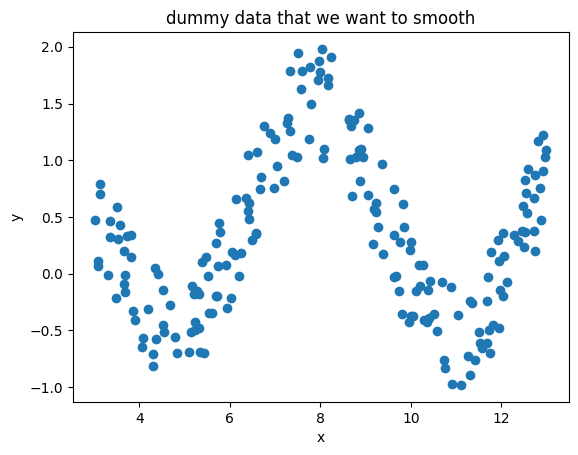

In [2]:
# generate some data:
xxx = 3 + 10*np.random.uniform(size=200)
yyy = np.sin(xxx) + np.random.uniform(size=len(xxx))

plt.scatter(xxx,yyy)
plt.title('dummy data that we want to smooth')
plt.xlabel('x')
plt.ylabel('y');

The following code produces a smoothed function fitting the data:

In [3]:
Nchunks = 15

ind = np.argsort(xxx)
y_sorted = yyy[ind]
x_sorted = xxx[ind]

x_range = max(x_sorted)-min(x_sorted)
x_bin_size = x_range/Nchunks

values, indices, counts = np.unique(np.digitize(x_sorted,np.arange(min(x_sorted),max(x_sorted),x_bin_size)),
                                    return_counts=True, 
                                    return_index=True)
chunked_y = np.split(y_sorted,indices)[1:]
mean_y = [np.mean(chunk) for chunk in chunked_y]
mean_x = np.arange(min(x_sorted),max(x_sorted),x_bin_size) + x_bin_size/2

def smoothed(x, x_ref, y_ref):
    return np.interp(x, x_ref, y_ref)

We can check that it works:

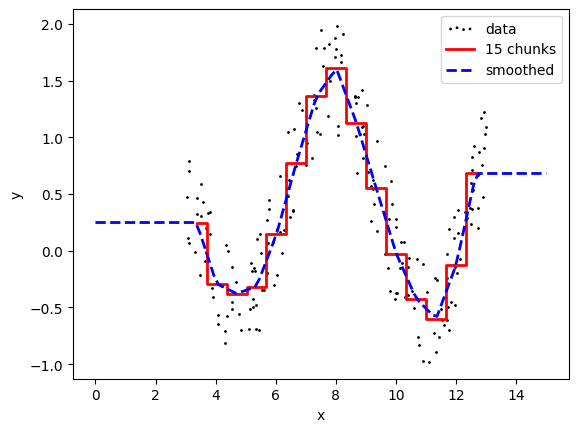

In [4]:
plt.scatter(xxx,yyy,label='data',s=1,c='k')
plt.step(mean_x, mean_y,'r-',lw=2,label=f'{Nchunks} chunks',where='mid')

xtoplot = np.linspace(0,15,100)
ytoplot = smoothed(xtoplot, mean_x, mean_y)
plt.plot(xtoplot, ytoplot, '--', color='b', lw=2, label='smoothed')
plt.legend(scatterpoints=4)
plt.xlabel('x')
plt.ylabel('y');

If we want to smooth another data set, we can copy the entire block, recalculate the mean X and mean Y values in chunks (calling them for example `mean_x_2` and `mean_y_2`), and pass them as arguments to the function `smoothed`. All the intermediate variables need to be explicitly given a new name, or else they will be overwritten.

Technically, we could make this process a little bit simpler by defining a "fitting function" with arguments `(Nchunks,X_data,y_data)` that would return `(mean_x,mean_y)`, then pass this to a "predict function" that takes input arguments `(X_new,mean_x,mean_y)`.

## Writing the process as a class

We can simplify the process by writing ChunkSmoother as a **class**:

In [5]:
class ChunkSmoother():
    
    def __init__(self, Nchunks=5):
        self.Nchunks = Nchunks

    def fit(self, Xdata, ydata):
        ind = np.argsort(Xdata)
        y_sorted = ydata[ind]
        x_sorted = Xdata[ind]
        
        x_range = max(x_sorted)-min(x_sorted)
        x_bin_size = x_range/self.Nchunks
        
        values, indices, counts = np.unique(np.digitize(x_sorted,np.arange(min(x_sorted),max(x_sorted),x_bin_size)),
                                            return_counts=True, 
                                            return_index=True)
        chunked_y = np.split(y_sorted,indices)[1:]
        self.mean_y = [np.mean(chunk) for chunk in chunked_y]
        self.mean_x = np.arange(min(x_sorted),max(x_sorted),x_bin_size) + x_bin_size/2
        return self # allows one-liners like: ChunkSmoother(12).fit(xxx,yyy).predict(xtoplot)

    def predict(self, X):
        return np.interp(X, self.mean_x, self.mean_y)

To use it we first create an instance with `object_smoother = ChunkSmoother()`.

Then we "insert" the data that we want to smooth, by calling the `fit` method on it: `object_smoother.fit(xxx,yyy)`.

The `mean_x` and `mean_y` values and other intermediate variables  are created, but they stay inside the class. If we create different smoothers with different values of `Nchunk` we don't have to worry about overwriting them or having to change the variable names.

Some methods return values (e.g. `predict`). Others just modify/create internal variables (e.g. `fit`), in which case having them return `self` allows for *method cascading*, e.g. `ChunkSmoother(12).fit(xxx,yyy).predict(xtoplot)`.

In [6]:
object_smoother = ChunkSmoother(Nchunks=8) # default is 5 chunks
object_smoother.fit(xxx,yyy)
# internal variables defined with self.ABC can be accessed from outside the class:
print(object_smoother.Nchunks)
print(object_smoother.mean_x)

8
[ 3.65574144  4.90099874  6.14625603  7.39151332  8.63677061  9.88202791
 11.1272852  12.37254249]


With this class structure, we can do everything in a single line! Trying three different `Nchunks` can be done in three lines:

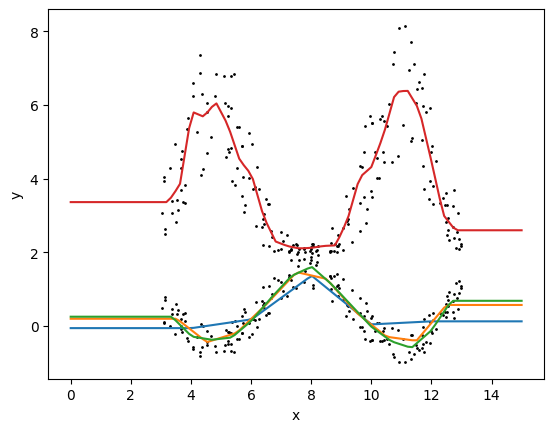

In [7]:
plt.scatter(xxx,yyy,c='k',s=1)
plt.plot(xtoplot, ChunkSmoother().fit(xxx,yyy).predict(xtoplot))   # one line!
plt.plot(xtoplot, ChunkSmoother(10).fit(xxx,yyy).predict(xtoplot)) # one line!
plt.plot(xtoplot, ChunkSmoother(15).fit(xxx,yyy).predict(xtoplot)) # one line!

# try some other data:
new_yyy = (1.5-yyy)**2 + 2
plt.scatter(xxx,new_yyy,c='k',s=1)
plt.plot(xtoplot, ChunkSmoother(25).fit(xxx,new_yyy).predict(xtoplot))

plt.xlabel('x')
plt.ylabel('y');